In [31]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [80]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
# from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, MobileNet, EfficientNetB1
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


In [33]:
import cv2

Загружаем картинки для сегментации (имена почти одинаковые: изображение.png - это сам кадр и изображение (1).png - это разметка)

Вот так загружаем с локального диска

In [34]:
import rarfile

rf = rarfile.RarFile("small_segment.rar")
for f in rf.infolist():
    print(f.filename, f.file_size)
    if f.filename == "README":
        print(rf.read(f))
rf.extractall()

labels/00_000200.png 19401
labels/00_000400.png 14502
labels/00_000600.png 19818
labels/00_000800.png 13554
labels/00_001000.png 14496
labels/00_001200.png 17371
labels/00_001400.png 12431
labels/00_001600.png 16390
labels/00_001800.png 16646
labels/00_002000.png 14844
labels/00_002200.png 14011
labels/00_002400.png 16921
labels/00_002600.png 15822
labels/00_002800.png 13681
labels/00_003000.png 13980
labels/00_003200.png 15122
labels/00_003400.png 13978
images/00_000200.png 791603
images/00_000400.png 816531
images/00_000600.png 862976
images/00_000800.png 836923
images/00_001000.png 829576
images/00_001200.png 822001
images/00_001400.png 858981
images/00_001600.png 797385
images/00_001800.png 850589
images/00_002000.png 818966
images/00_002200.png 641760
images/00_002400.png 714888
images/00_002600.png 774166
images/00_002800.png 890605
images/00_003000.png 837876
images/00_003200.png 755342
images/00_003400.png 695524
labels/ 0
images/ 0


Задаю маршрут для чтения

In [35]:
PAHT_label = 'labels/'
PAHT_image = 'images/'

In [36]:
import os, fnmatch
imag = os.listdir(PAHT_label)
imag_label = os.listdir(PAHT_image)

In [37]:
imag,imag_label

(['00_002600.png',
  '00_003200.png',
  '00_002400.png',
  '00_000200.png',
  '00_000600.png',
  '00_002200.png',
  '00_001800.png',
  '00_001600.png',
  '00_001200.png',
  '00_002000.png',
  '00_001400.png',
  '00_003000.png',
  '00_003400.png',
  '00_000800.png',
  '00_002800.png',
  '00_001000.png',
  '00_000400.png'],
 ['00_002600.png',
  '00_003200.png',
  '00_002400.png',
  '00_000200.png',
  '00_000600.png',
  '00_002200.png',
  '00_001800.png',
  '00_001600.png',
  '00_001200.png',
  '00_002000.png',
  '00_001400.png',
  '00_003000.png',
  '00_003400.png',
  '00_000800.png',
  '00_002800.png',
  '00_001000.png',
  '00_000400.png'])

#Загружаем и уменьшаем картинки

можно обойтись исходным рахзмером или взять другой

ВАЖНО - размер по обеим сторонам должен делиться на 2 несколько раз (сколько будет сжатий кадра)

In [38]:
images = []
segments = []
image_size = (200,600)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))


Посмотрели на входные кадры

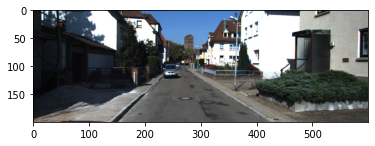

In [39]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

Посмотрим на цели

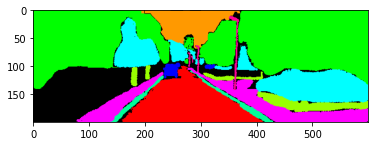

In [40]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

#Создаём обучающую выборку

Собираем входные примеры:

In [41]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [42]:
print(xTrain_Test.shape)

(17, 200, 600, 3)


Порстроим цвета , воспринимаемого диапазона для сегментированной картинки - это результат разметки, которую принесет разметчик

Color Coding:

Name	(r,g,b)	    7-Class mapping

Car	  ( 0, 0,255)	Object

Road	(255, 0, 0)	Road

Mark	(255,255, 0)	Road

Building	( 0,255, 0)	Building

Sidewalk	(255, 0,255)	Road

Tree/Bush	( 0,255,255)	Tree/Bush

Pole	(255, 0,153)	Sign/Pole

Sign	(153, 0,255)	Sign/Pole

Person	( 0,153,255)	Object

Wall	(153,255, 0)	Building

Sky	(255,153, 0)	Sky

Curb	( 0,255,153)	Road

Grass/Dirt	( 0,153,153)	Grass/Dirt

Void	( 0, 0, 0)	Void



Делаем конвертер в one-hot_encoding для выходных примеров

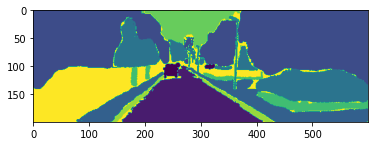

In [43]:
def Color2index(y):
  arr_col=[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  


In [44]:
np.sum(cat_yi[100:,:100,1] )

0.0

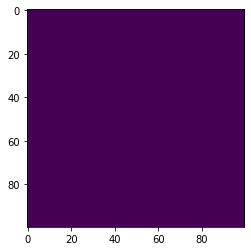

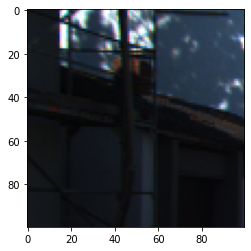

In [45]:
plt.imshow(cat_yi[:100,:100,3])
plt.show()
plt.imshow(xTrain_Test[0,:100,:100,:]/255)
plt.show()

In [46]:
cat_yi.shape

(200, 600, 14)

Сегментированную картинку в  One hot encoding (разметка на 14 классов)**

In [47]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [48]:
print(yTrain_Test.shape)

(17, 200, 600, 14)


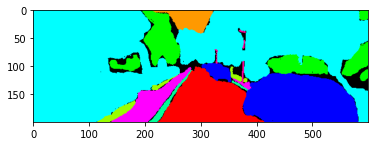

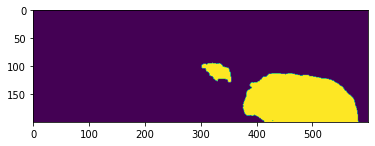

In [49]:
n = 10
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,0]
plt.imshow(img.astype(float))
plt.show()

Делим на тест и трейн по числу N

In [50]:
N = 12
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [51]:
yTest.shape

(5, 200, 600, 14)

In [52]:
print(xTrain.shape)
print(yTrain.shape)

(12, 200, 600, 3)
(12, 200, 600, 14)


## Создаём и обучаем сеть

## **Претренированная  Unet**

In [53]:
U_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

In [54]:
U_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 150, 128)      0     

In [55]:
def bloc_transpose(x,block_out, numb_filter = [256,128]):
  x = concatenate([x, block_out])
  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 
  x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [56]:
def unet_pre_train(num_classes = 13, input_shape= (200, 600, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    x = pre_trained_model.layers[13].output # конец сверток
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output # первое уменьшение размера
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x, block_4_out, numb_filter = [256,128])
    

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_3_out, numb_filter = [128,64])
    

    # UP 3
  

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_2_out, numb_filter = [64,32])


    # UP 4
   
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [75]:
U_model = unet_pre_train(num_classes = 14, input_shape= (200, 600, 3))

# plot_model(U_model, to_file='U_model.png')

KerasTensor(type_spec=TensorSpec(shape=(None, 25, 75, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 50, 150, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 300, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 600, 64) 1792        input_9[0][0]         

In [62]:
from IPython.display import clear_output

In [63]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    Ipred = self.model(xTest[:1])

    k = Ipred.shape[3]
    if k>4:
      k = 4
    print('Predict')
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(Ipred[0,:,:,i])
    
    plt.show() 
    print('True') 
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(yTest[0,:,:,i])
    
    plt.show()

    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/10
4/4 [==============================] - 19s 5s/step - loss: 2.6672 - dice_coef: 0.0979 - val_loss: 3.5739 - val_dice_coef: 0.2342
Predict


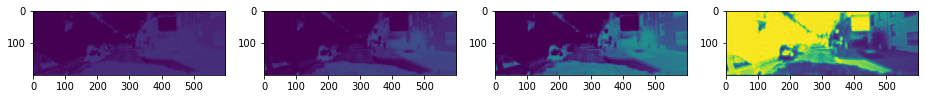

True


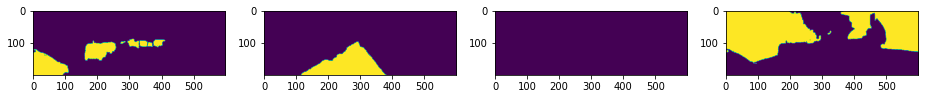


Sample Prediction after epoch 1

Epoch 2/10
4/4 [==============================] - 22s 6s/step - loss: 1.9393 - dice_coef: 0.2349 - val_loss: 2.8945 - val_dice_coef: 0.2389
Predict


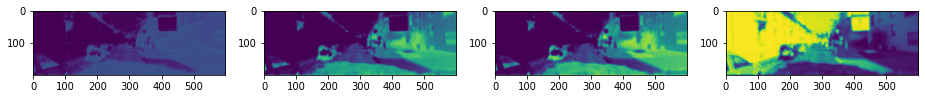

True


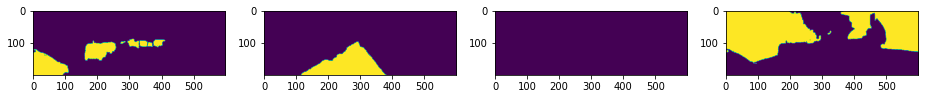


Sample Prediction after epoch 2

Epoch 3/10
4/4 [==============================] - 23s 6s/step - loss: 1.6116 - dice_coef: 0.3357 - val_loss: 2.4560 - val_dice_coef: 0.2283
Predict


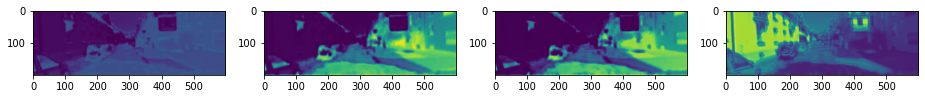

True


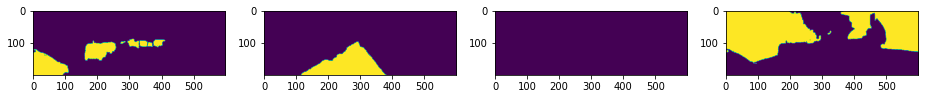


Sample Prediction after epoch 3

Epoch 4/10
4/4 [==============================] - 23s 6s/step - loss: 1.5764 - dice_coef: 0.3599 - val_loss: 2.4071 - val_dice_coef: 0.2228
Predict


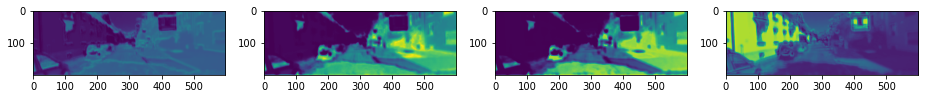

True


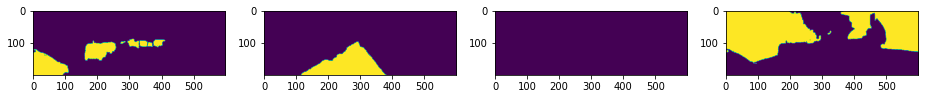


Sample Prediction after epoch 4

Epoch 5/10
4/4 [==============================] - 24s 7s/step - loss: 1.4640 - dice_coef: 0.3709 - val_loss: 2.3386 - val_dice_coef: 0.2348
Predict


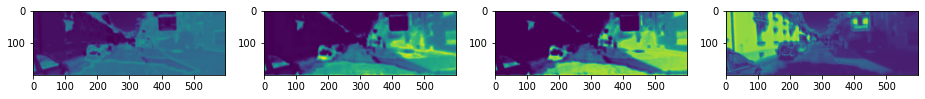

True


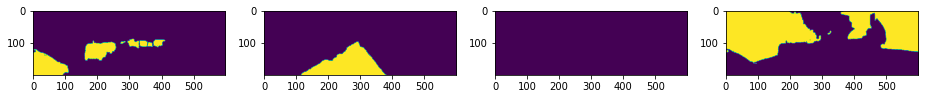


Sample Prediction after epoch 5

Epoch 6/10
4/4 [==============================] - 25s 7s/step - loss: 1.4125 - dice_coef: 0.3751 - val_loss: 2.2538 - val_dice_coef: 0.2317
Predict


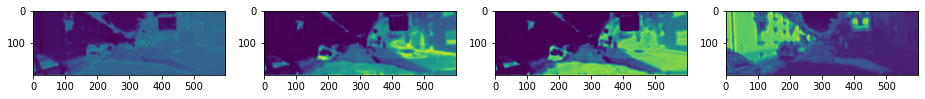

True


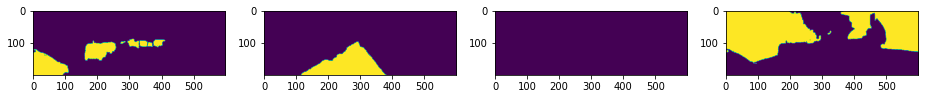


Sample Prediction after epoch 6

Epoch 7/10
4/4 [==============================] - 24s 7s/step - loss: 1.3346 - dice_coef: 0.4037 - val_loss: 2.2611 - val_dice_coef: 0.2214
Predict


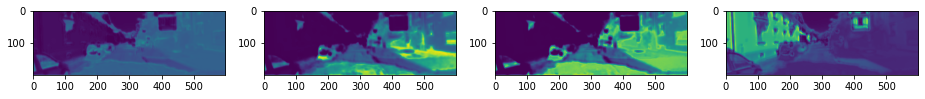

True


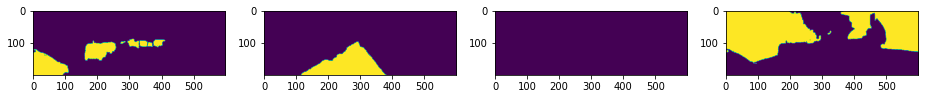


Sample Prediction after epoch 7

Epoch 8/10
4/4 [==============================] - 24s 7s/step - loss: 1.3249 - dice_coef: 0.4105 - val_loss: 2.1386 - val_dice_coef: 0.2171
Predict


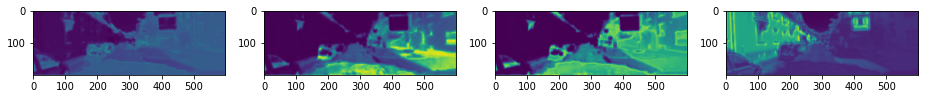

True


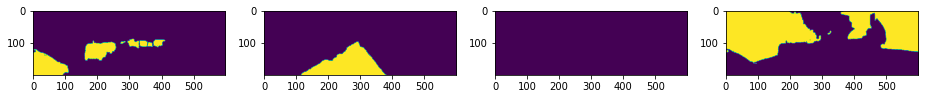


Sample Prediction after epoch 8

Epoch 9/10
4/4 [==============================] - 25s 7s/step - loss: 1.3049 - dice_coef: 0.4230 - val_loss: 2.1115 - val_dice_coef: 0.1973
Predict


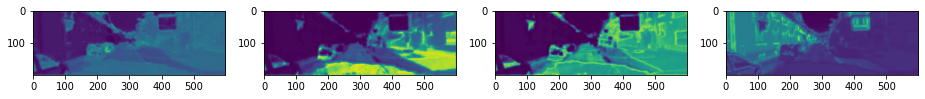

True


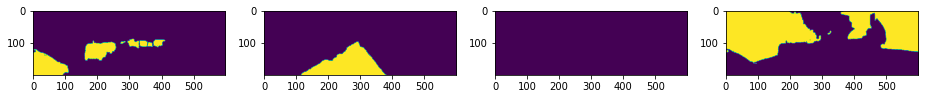


Sample Prediction after epoch 9

Epoch 10/10
4/4 [==============================] - 25s 7s/step - loss: 1.2361 - dice_coef: 0.4275 - val_loss: 2.1206 - val_dice_coef: 0.1907
Predict


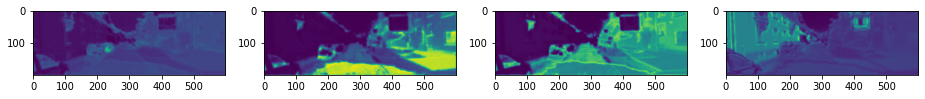

True


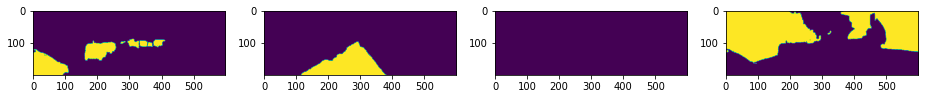


Sample Prediction after epoch 10



In [64]:
history = U_model.fit(xTrain, yTrain, epochs=10, batch_size=3, validation_data=(xTrain, yTrain), callbacks = [tf.keras.callbacks.EarlyStopping( patience=5 ), DisplayCallback()])

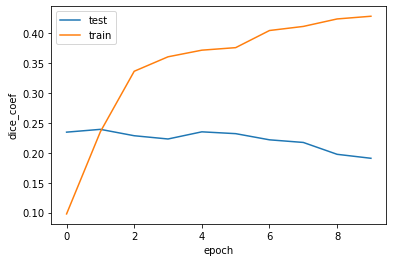

In [65]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

### Распознаём обучающую выборку

In [66]:
predu = U_model.predict(xTest)
print(predu.shape)

(5, 200, 600, 14)


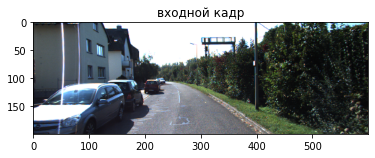

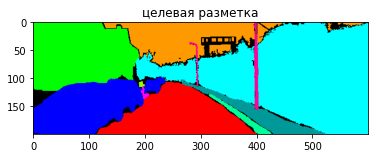

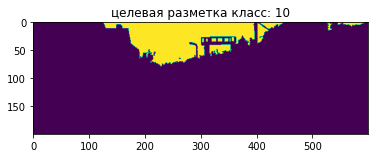

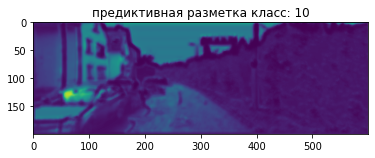

In [67]:
n = 1
class_ = 10
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()


### Возьмем другую модель, например EfficientNetB1

In [81]:
E_model = EfficientNetB1(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

27025408/27018416 [==============================] - 6s 0us/step


In [82]:
E_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 200, 600, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
normalization (Normalization)   (None, 200, 600, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 201, 601, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [87]:
def enet_pre_train(num_classes = 13, input_shape= (100, 300, 3)):    
    pre_trained_model = EfficientNetB1(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:28]:
      layer.trainable = False
    x = pre_trained_model.layers[24].output # конец сверток
    print(x.shape)
    block_4_out = pre_trained_model.layers[16].output
    print(block_4_out.shape)
    block_3_out = pre_trained_model.layers[14].output
    print(block_3_out.shape)
    block_2_out = pre_trained_model.layers[5].output # первое уменьшение размера
    print(block_2_out.shape)
    img_input = pre_trained_model.inputs

    # UP 1

    # добавили перенос из понижаюшего плеча
    x = bloc_transpose(x, block_4_out, numb_filter = [256,128])
    

    # добавили перенос из понижаюшего плеча
    x = bloc_transpose(x,block_3_out, numb_filter = [128,64])
    

    # UP 3
  

    # добавили перенос из понижаюшего плеча
    x = bloc_transpose(x,block_2_out, numb_filter = [32,16])


    # UP 4
   
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [88]:
E_model = enet_pre_train(num_classes = 14, input_shape= (200, 600, 3))

# plot_model(MN_model, to_file='MN_model.png')

(None, 100, 300, 16)
(None, 100, 300, 16)
(None, 100, 300, 32)
(None, 100, 300, 32)


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 200, 600, 16), (None, 100, 300, 32)]

In [62]:
from IPython.display import clear_output

In [63]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    Ipred = self.model(xTest[:1])

    k = Ipred.shape[3]
    if k>4:
      k = 4
    print('Predict')
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(Ipred[0,:,:,i])
    
    plt.show() 
    print('True') 
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(yTest[0,:,:,i])
    
    plt.show()

    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/10
4/4 [==============================] - 19s 5s/step - loss: 2.6672 - dice_coef: 0.0979 - val_loss: 3.5739 - val_dice_coef: 0.2342
Predict


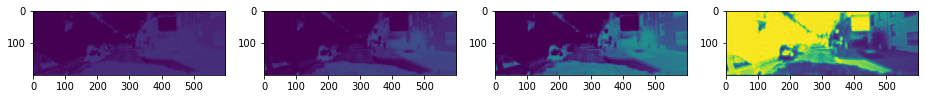

True


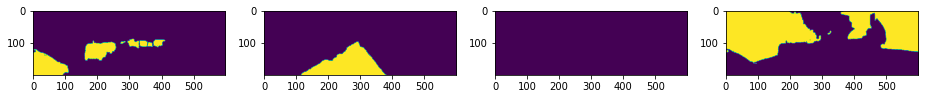


Sample Prediction after epoch 1

Epoch 2/10
4/4 [==============================] - 22s 6s/step - loss: 1.9393 - dice_coef: 0.2349 - val_loss: 2.8945 - val_dice_coef: 0.2389
Predict


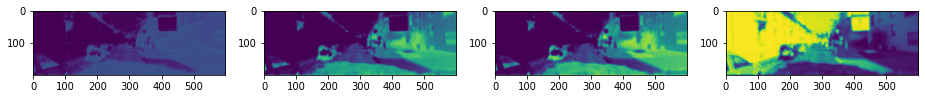

True


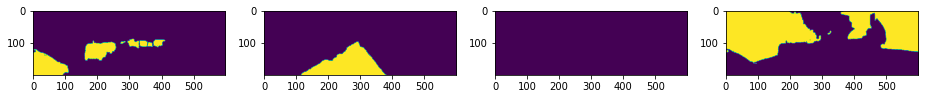


Sample Prediction after epoch 2

Epoch 3/10
4/4 [==============================] - 23s 6s/step - loss: 1.6116 - dice_coef: 0.3357 - val_loss: 2.4560 - val_dice_coef: 0.2283
Predict


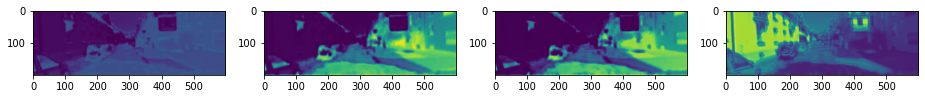

True


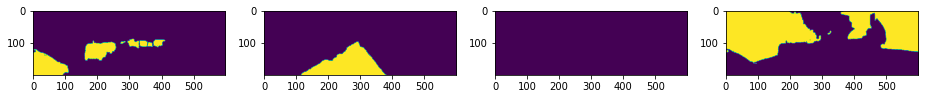


Sample Prediction after epoch 3

Epoch 4/10
4/4 [==============================] - 23s 6s/step - loss: 1.5764 - dice_coef: 0.3599 - val_loss: 2.4071 - val_dice_coef: 0.2228
Predict


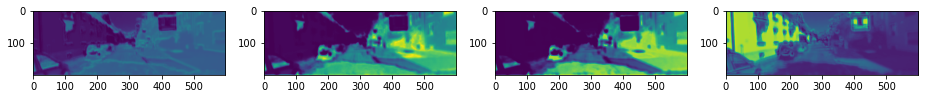

True


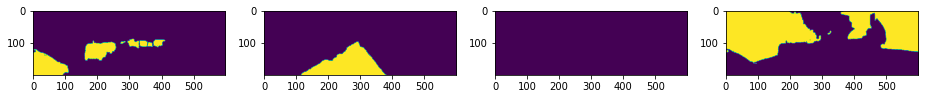


Sample Prediction after epoch 4

Epoch 5/10
4/4 [==============================] - 24s 7s/step - loss: 1.4640 - dice_coef: 0.3709 - val_loss: 2.3386 - val_dice_coef: 0.2348
Predict


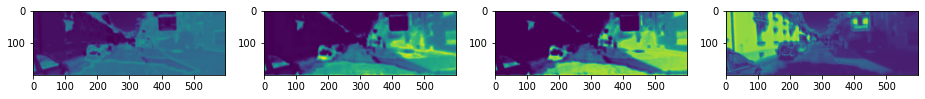

True


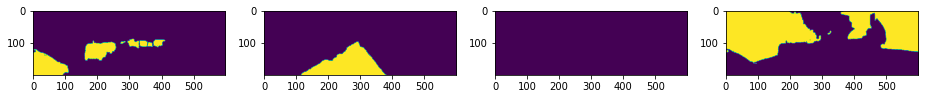


Sample Prediction after epoch 5

Epoch 6/10
4/4 [==============================] - 25s 7s/step - loss: 1.4125 - dice_coef: 0.3751 - val_loss: 2.2538 - val_dice_coef: 0.2317
Predict


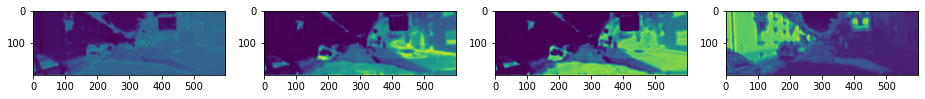

True


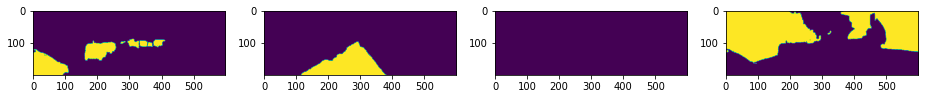


Sample Prediction after epoch 6

Epoch 7/10
4/4 [==============================] - 24s 7s/step - loss: 1.3346 - dice_coef: 0.4037 - val_loss: 2.2611 - val_dice_coef: 0.2214
Predict


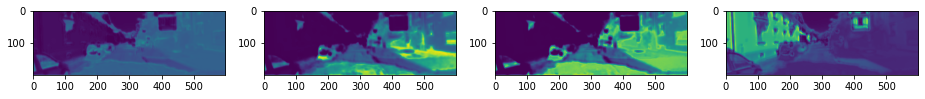

True


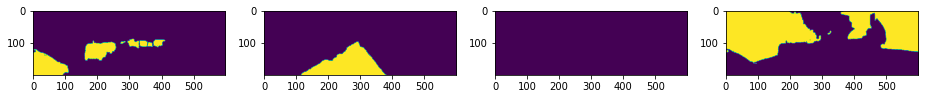


Sample Prediction after epoch 7

Epoch 8/10
4/4 [==============================] - 24s 7s/step - loss: 1.3249 - dice_coef: 0.4105 - val_loss: 2.1386 - val_dice_coef: 0.2171
Predict


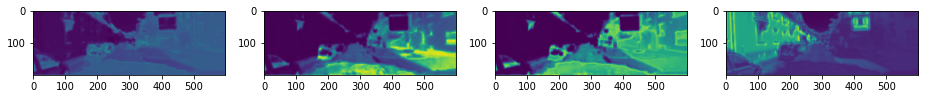

True


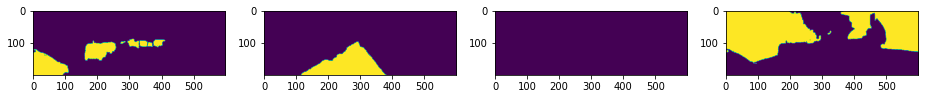


Sample Prediction after epoch 8

Epoch 9/10
4/4 [==============================] - 25s 7s/step - loss: 1.3049 - dice_coef: 0.4230 - val_loss: 2.1115 - val_dice_coef: 0.1973
Predict


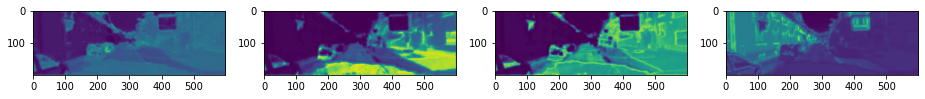

True


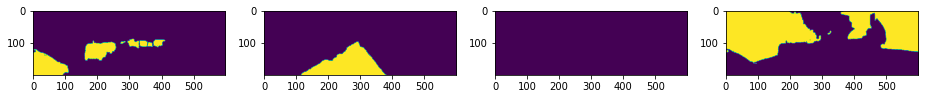


Sample Prediction after epoch 9

Epoch 10/10
4/4 [==============================] - 25s 7s/step - loss: 1.2361 - dice_coef: 0.4275 - val_loss: 2.1206 - val_dice_coef: 0.1907
Predict


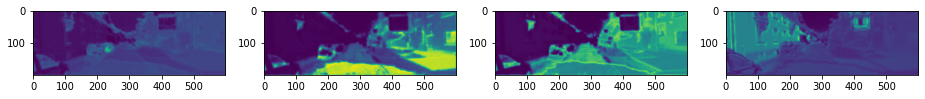

True


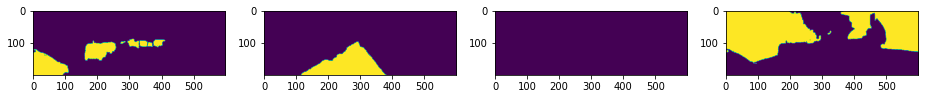


Sample Prediction after epoch 10



In [64]:
history = U_model.fit(xTrain, yTrain, epochs=10, batch_size=3, validation_data=(xTrain, yTrain), callbacks = [tf.keras.callbacks.EarlyStopping( patience=5 ), DisplayCallback()])

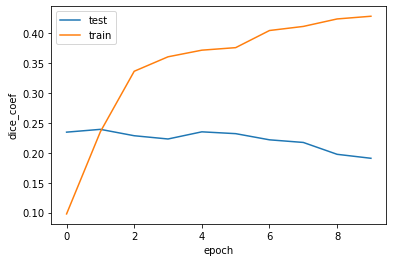

In [65]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

### Распознаём обучающую выборку

In [66]:
predu = U_model.predict(xTest)
print(predu.shape)

(5, 200, 600, 14)


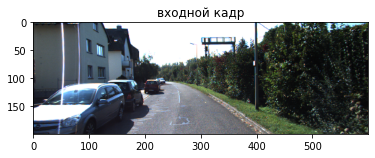

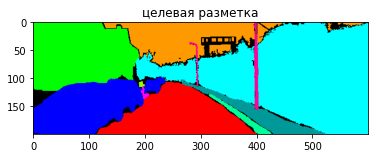

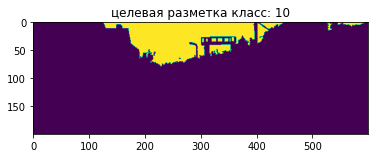

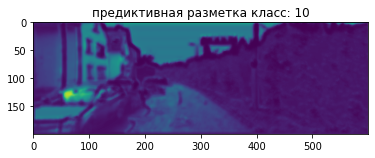

In [67]:
n = 1
class_ = 10
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()
